# Testing HW equilibrium


In [1]:
library(data.table)
library(lfa)
library(ggplot2)

output_path = "../output/data/"

In [2]:
# read data
dat = fread(paste0(output_path, "agents-snp-hw.csv"))
params = fread(paste0(output_path, "param-snp-hw.csv"))
# create id
dat[, id := .GRP, .(iteration)]
# snp text to numeric
vars = paste0("snp", 1:100)
dat[, (vars) := tstrsplit(snps, ",", fixed=TRUE), id]
dat[, (vars) := lapply(.SD, function(x) as.numeric(gsub(".+=|\\}", "", x))), .SDcols = vars]
df = merge(dat, params[, .(iteration, replicate, random_mating)], by = c("iteration", "replicate"))

In [3]:
# compute p-values
getHWpvalues = function(data, rep = "replicates", k = 1, nsample = NULL) {
    nr = nrow(data)
    
    if (is.null(sample)) {
        values = sort(unique(data$iteration))
    } else {
        values = sample(unique(data$iteration), nsample)
    }
    

    pvalues = NULL
    vars = names(data)[grepl("^snp[0-9]+$", names(data))] 
    for (i in values) {
        temp = copy(data[iteration == i, ..vars])
        m = as.matrix(transpose(temp))
        # use k=1 for standard HW test
        LF = lfa(m, k)
        pvalues = c(pvalues, sHWE(m, LF, 4))
    }
    print(summary(pvalues))
    return(pvalues)
}


# Contrasting generation 0 and 100

In [ ]:
# pvalues0rm0 = getHWpvalues(df[generation == 0 &  random_mating == 0])
# pvalues100rm0 = getHWpvalues(df[generation == 100 &  random_mating == 0])
# pvalues0rm05 = getHWpvalues(df[generation == 0 &  random_mating == 0.5])
# pvalues100rm05 = getHWpvalues(df[generation == 100 &  random_mating == 0.5])
# pvalues0rm1 = getHWpvalues(df[generation == 0 &  random_mating == 1])
pvalues100rm1 = getHWpvalues(df[generation == 100 &  random_mating == 1], nsample = 3)


## Strong assortative mating (random mating = 0)

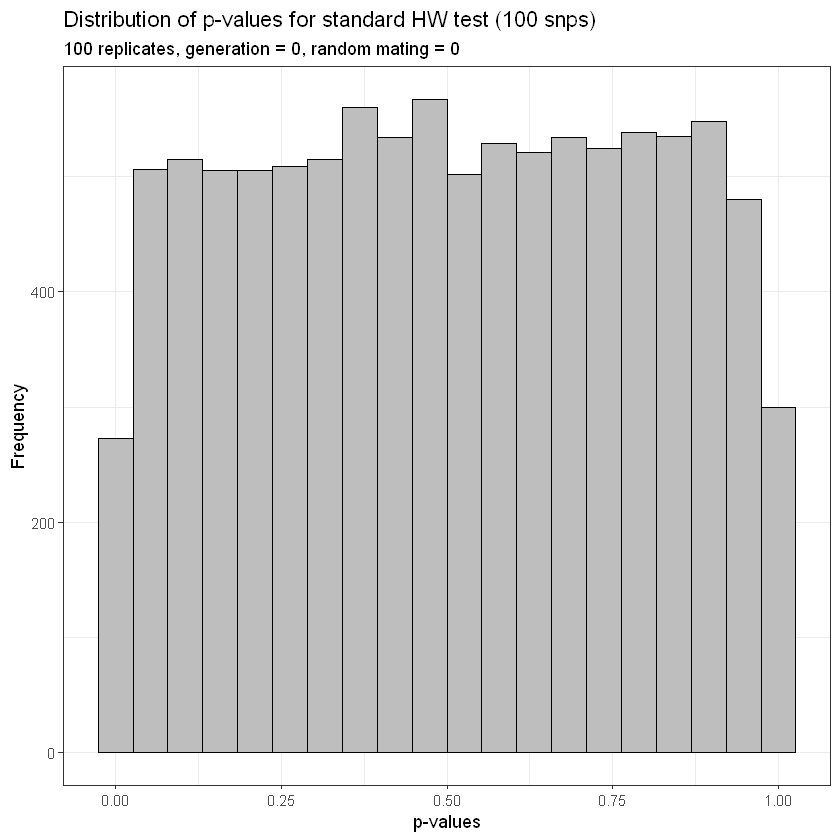

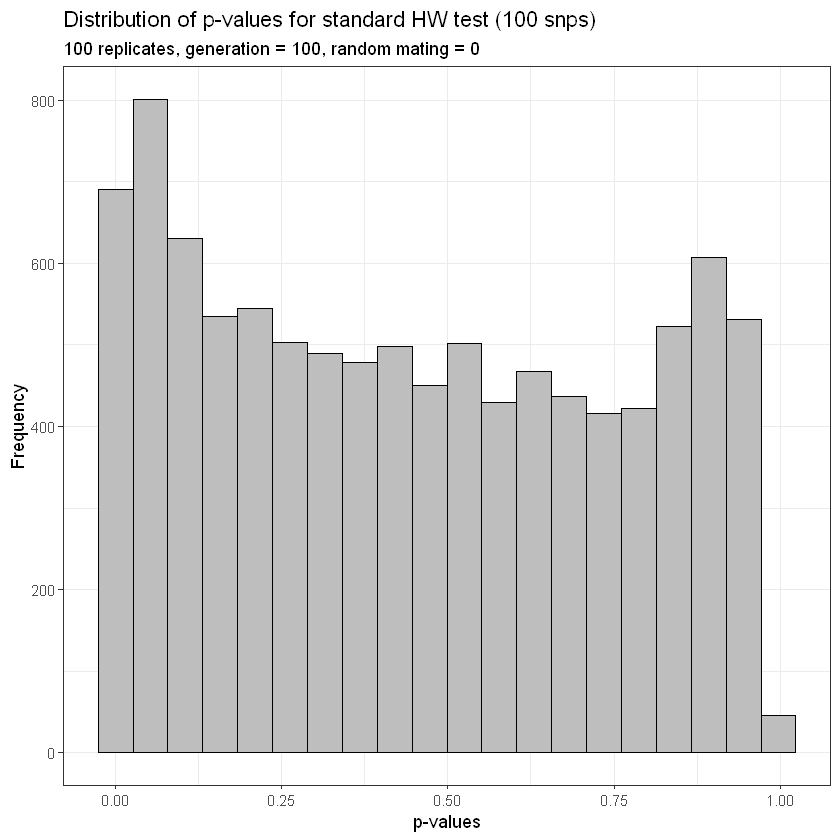

In [52]:
ggplot() + aes(pvalues0rm0)+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
    title = "Distribution of p-values for standard HW test (100 snps)", 
    subtitle = "100 replicates, generation = 0, random mating = 0")
ggplot() + aes(pvalues100rm0)+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
    title = "Distribution of p-values for standard HW test (100 snps)",  
    subtitle = "100 replicates, generation = 100, random mating = 0")



## Medium assortative mating (random mating = 0.5)

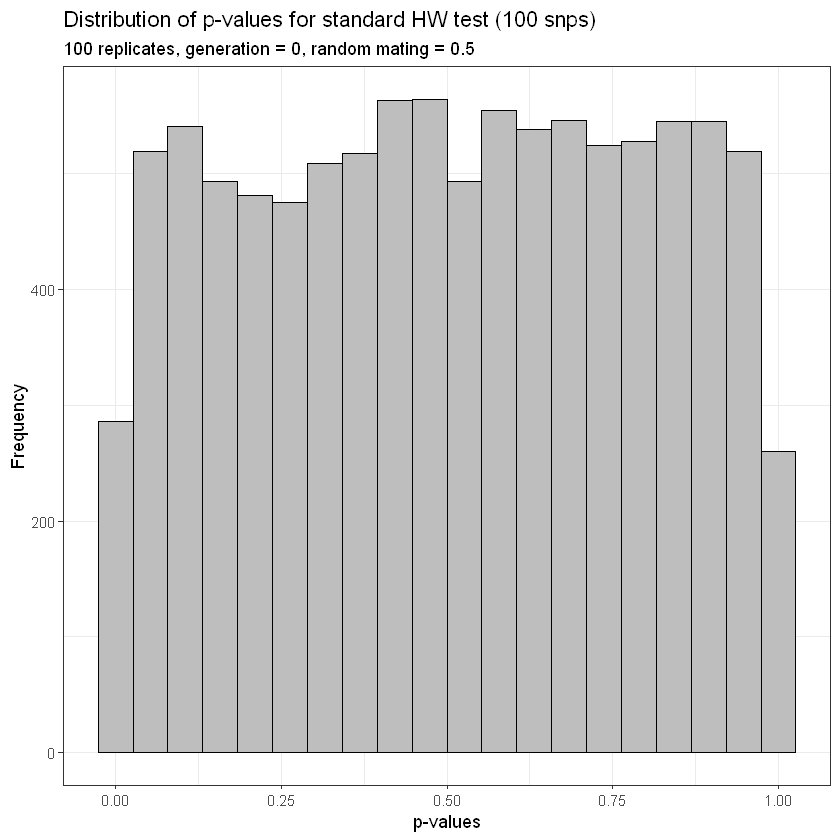

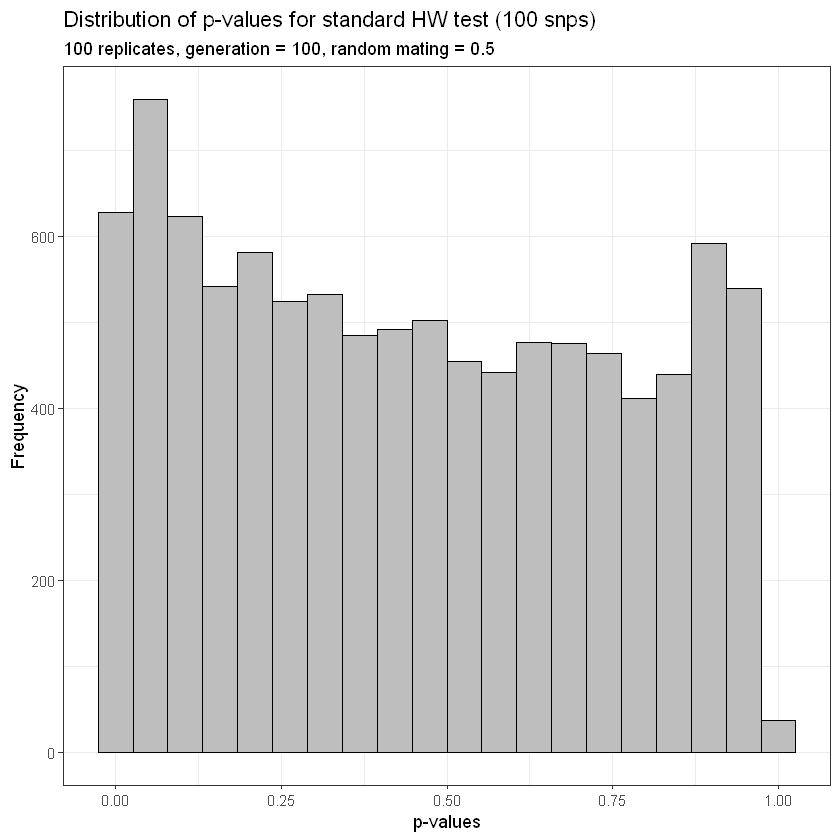

In [53]:
ggplot() + aes(pvalues0rm05)+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
    title = "Distribution of p-values for standard HW test (100 snps)", 
    subtitle = "100 replicates, generation = 0, random mating = 0.5")
ggplot() + aes(pvalues100rm05)+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
    title = "Distribution of p-values for standard HW test (100 snps)",  
    subtitle = "100 replicates, generation = 100, random mating = 0.5")



## No assortative mating (random mating = 1)

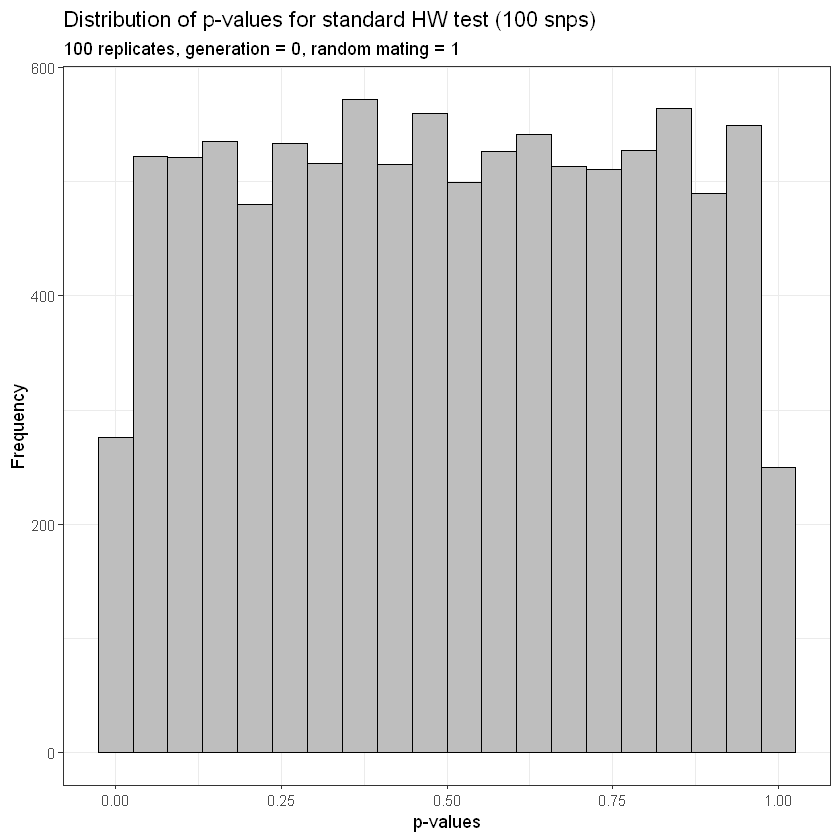

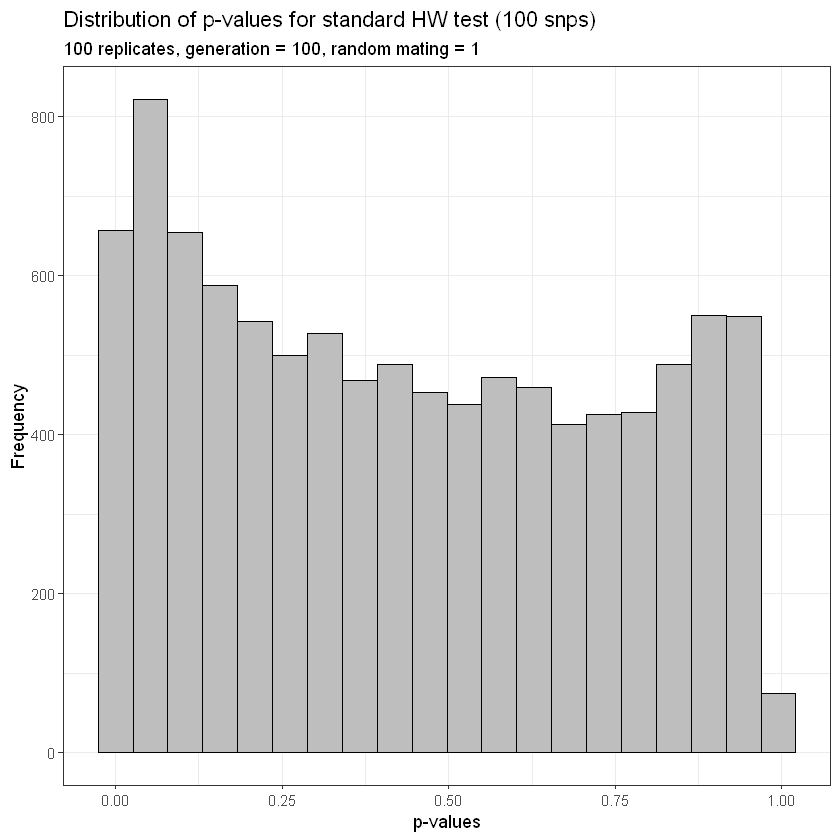

In [54]:
ggplot() + aes(pvalues0rm1)+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
    title = "Distribution of p-values for standard HW test (100 snps)", 
    subtitle = "100 replicates, generation = 0, random mating = 1")
ggplot() + aes(pvalues100rm1)+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
    title = "Distribution of p-values for standard HW test (100 snps)",  
    subtitle = "100 replicates, generation = 100, random mating = 1")
